In [1]:
import jax.numpy as jnp
import jax.lax as lax
import matplotlib.pyplot as plt


from scipy.integrate import simpson
import numpy as np
import pymaster as nmt
import healpy as hp
import gc
import time
from tqdm import tqdm
%matplotlib inline

In [2]:
((3/(4*np.pi * 1.7e-24))*8e33/(1e9*365*24*3600*100)**2)/3.1e18

36.43993122259402

In [2]:
def build_binning_matrix(edges, lmax):
    nbins = len(edges) - 1
    lmin = edges[0]
    B = np.zeros((nbins, lmax - lmin))
    ell_eff = np.zeros(nbins)
    for b in range(nbins):
        ell_min, ell_max = edges[b], edges[b + 1]
        ells_in_bin = np.arange(ell_min, ell_max)
        Δℓ = len(ells_in_bin)
        if Δℓ > 0:
            B[b, ells_in_bin - lmin] = 1.0 / Δℓ
            ell_eff[b] = np.mean(ells_in_bin)
    return B, ell_eff

In [48]:
from utils2 import *
n_sources = [1000, 3000, 5000]
nside = 256
npix = hp.nside2npix(nside)
sel = np.ones(npix)
nside = 256
nell = 30
lmin = 1
lmax = 3*nside - 1
edges = np.unique(np.geomspace(lmin,3*nside - 1,nell).astype(int))
# edges = np.arange(lmin, 3*nside + 1)
cl_DMDM = np.load("/home/s59efara_hpc/covariance/test_cl_kappadm.npy")[:, 0 ,0]
alm = hp.synalm(cls=cl_DMDM, lmax = lmax)
map = hp.alm2map(alm, nside=nside, lmax=lmax)



variance_list = []
for n_samples in n_sources:
    print('sampling on a sphere')
    (gl ,gb),  _ = get_pos(n_samples, 'random', sel, nside)
    
    sin_gl = np.sin(gl*np.pi/180)
    cos_gl = np.cos(gl*np.pi/180)
    sin_gb = np.sin(gb*np.pi/180)
    cos_gb = np.cos(gb*np.pi/180)

    cos_theta = sin_gb[None,:] * sin_gb[:, None] + cos_gb[None,:] * cos_gb[:, None] * np.cos(gl[None,:]*np.pi/180 - gl[:, None]*np.pi/180)
    np.fill_diagonal(cos_theta, 1)
    
    print('calculating the mode coupling matrix')
    ipix = hp.ang2pix(nside, gl, gb, lonlat=True)
    w = np.ones_like(ipix)
    # beware of the binning scheme and the values to be added to the  
    b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
    f_vals = map[ipix] - np.mean(map[ipix])
    f_nmt = nmt.NmtFieldCatalog(positions = [gl, gb], weights=w, field = f_vals, lmax=b.lmax, lonlat=True)
    wasp = nmt.NmtWorkspace.from_fields(f_nmt, f_nmt, b)
    
    '''
    Sl_coupled = nmt.compute_coupled_cell(f_nmt, f_nmt) # the coupled, noise subtracted power spectrum 
    
    Nf = f_nmt.Nf
    Cl = Sl_coupled + Nf 
    Sl = wasp.decouple_cell(Sl_coupled)

    Rl = Sl + Nf'''
    ells = b.get_effective_ells()
    mcm = jnp.asarray(wasp.get_coupling_matrix())
    mcm_inv = np.linalg.inv(mcm)
    var_f = np.var(f_vals)
    print('calculating Paij')
    # Recurrence: (l+1) P_{l+1} = (2l+1)x P_l - l P_{l-1}
    def body_fn(carry, l):
        P_lm1, P_l = carry
        P_lp1 = ((2*l + 1)*cos_theta*P_l - l*P_lm1) / (l + 1)
        return (P_l, P_lp1), P_lp1

    # Initialize P_0 = 1, P_1 = x
    carry_init = (jnp.ones_like(cos_theta), cos_theta)

    # Run scan from l=1 to Lmax-1
    _, P_all = lax.scan(body_fn, carry_init, jnp.arange(2, edges[-1]))
    P_all = jnp.concatenate([
        jnp.ones_like(cos_theta)[None, :],   # P_0
        cos_theta[None, :],                  # P_1
        P_all                        # P_2 ... P_Lmax
    ], axis=0)
    
    
    
    Binning, ell_eff = build_binning_matrix(edges, edges[-1])
    Binning = jnp.array(Binning)

    
    print('summing terms')
    direct_sum = jnp.einsum('i, j, aij, bij->ab', w**2, w**2, P_all, P_all)/(4*np.pi)**2 - jnp.sum(w**4)/(4*np.pi)**2
    matrix_term = 2*direct_sum*((var_f)**2)
    # term1 = jnp.einsum('')
    term1 = mcm_inv @ matrix_term @ mcm_inv.T
    term1 = term1[lmin:, lmin:]
    term1_binned = Binning @ term1 @ Binning.T
    variance_list.append(jnp.diag(term1_binned))
    

sampling on a sphere
calculating the mode coupling matrix
calculating Paij
summing terms
sampling on a sphere
calculating the mode coupling matrix
calculating Paij
summing terms
sampling on a sphere
calculating the mode coupling matrix
calculating Paij
summing terms


In [42]:
data = np.load('/home/s59efara_hpc/covariance/data_sets/varied_numbers_compare_field_variance_wide_bins.npy')

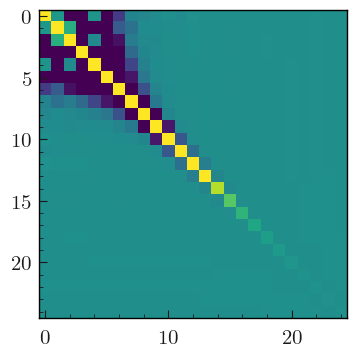

In [50]:
plt.imshow(term1_binned, vmin=-3, vmax=3)

In [43]:
ells = b.get_effective_ells()

In [44]:
import plothist

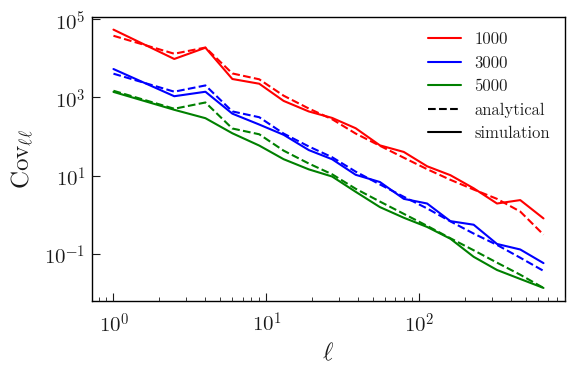

In [45]:
color = ['r', 'b', 'g']

# fig, ax = plt.subplots(figsize = (12, 8))

for i in range(len(n_sources)):
    ls, cls, sigma, Nf, _ = data[i]
    plt.loglog(ls, sigma, color = color[i], label = n_sources[i])
    plt.loglog(ells, variance_list[i], ls = '--', color = color[i])
    # sigma_th = (2*(clth_binned + 4*np.pi*field_variance/n_sources_list[i])**2)/(delta_ell*(2*ells + 1))
# plt.loglog(np.arange(0, edges[-1], 1), jnp.diag(Cov_N), label='full variance')

plt.axhline(-1, ls = '--', color = 'black', label = 'analytical')
plt.axhline(-1, color = 'black', label = 'simulation')


plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cov_{\ell \ell}$')
plt.legend()
plt.tight_layout()
plt.savefig('figs/factor2_comparison.png', dpi = 300)
# cl_jax_nsource_1000.png', dpi = 300, bbox_inches='tight')

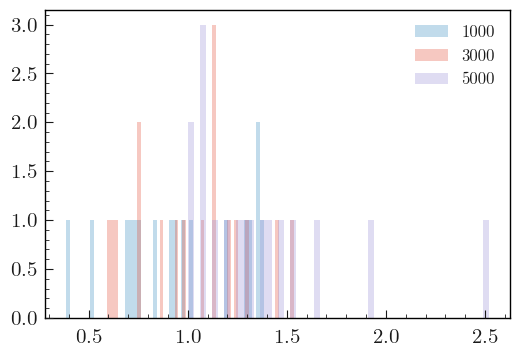

In [47]:
for i in range(len(n_sources)):
    ls, cls, sigma, Nf, _ = data[i]
    
    plt.hist(variance_list[i]/ sigma, bins = 50, label = n_sources[i], alpha = 0.3)
    
plt.legend()